In [23]:
# Globla variable
flag_OneHotDone = False

import pandas as pd
import numpy  as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter

import category_encoders as ce 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

import calendar
from datetime import datetime

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.options.display.float_format    = '{:,.3f}'.format  


In [24]:
hourly_core = pd.read_csv('data/mod_data/hour_mod.csv')
hourly_core['date_day'] = pd.to_datetime(hourly_core['date_day'], format='%Y-%m-%d')
hourly_core['day'] = hourly_core.date_day.dt.day
hourly_core = hourly_core.drop(columns=['instant', 'date_day', 'season_name', 'weekday_name', 'daytime', 'hour_time', 'weather_desc', 'casual', 'registered'])

df = hourly_core[['season', 'year', 'month', 'day', 'hour', 'weekday', 'is_holiday', 'is_workday', 
                          'weather', 'temp', 'temp_feel', 'humidity', 'windspeed', 'total_riders']].copy()



In [25]:
dict_map = {1: 'clear', 2: 'foggy', 3: 'inclement', 4: 'crap'}
df['weather'] = df['weather'].map(dict_map)

In [26]:
ordFeatures   = ['hour']
boolFeatures  = ['is_holiday','is_workday']
contFeatures  = ['temp','temp_feel','humidity','windspeed']
nomFeatures   = ['season','weekday','weather']
target        = ['total_riders']

df.head()

,season,year,month,day,hour,weekday,is_holiday,is_workday,weather,temp,temp_feel,humidity,windspeed,total_riders
0,1,2011,1,1,0,6,0,0,clear,3.280,3.001,81.000,0.000,16
1,1,2011,1,1,1,6,0,0,clear,2.340,1.998,80.000,0.000,40
2,1,2011,1,1,2,6,0,0,clear,2.340,1.998,80.000,0.000,32
3,1,2011,1,1,3,6,0,0,clear,3.280,3.001,75.000,0.000,13
4,1,2011,1,1,4,6,0,0,clear,3.280,3.001,75.000,0.000,1


In [27]:
# One-hot encoding for category 'weathersit' 
if not flag_OneHotDone:
    weathersit_dummy = pd.get_dummies(df.weather)
    df               = pd.concat([df, weathersit_dummy],axis=1)
    
    #   This prevent repetitive columns for One-Hot
    flag_OneHotDone = True

In [28]:
df.head()

,season,year,month,day,hour,weekday,is_holiday,is_workday,weather,temp,temp_feel,humidity,windspeed,total_riders,clear,crap,foggy,inclement
0,1,2011,1,1,0,6,0,0,clear,3.280,3.001,81.000,0.000,16,1,0,0,0
1,1,2011,1,1,1,6,0,0,clear,2.340,1.998,80.000,0.000,40,1,0,0,0
2,1,2011,1,1,2,6,0,0,clear,2.340,1.998,80.000,0.000,32,1,0,0,0
3,1,2011,1,1,3,6,0,0,clear,3.280,3.001,75.000,0.000,13,1,0,0,0
4,1,2011,1,1,4,6,0,0,clear,3.280,3.001,75.000,0.000,1,1,0,0,0


In [29]:
df.isna().sum()

season          0
year            0
month           0
day             0
hour            0
weekday         0
is_holiday      0
is_workday      0
weather         0
temp            0
temp_feel       0
humidity        0
windspeed       0
total_riders    0
clear           0
crap            0
foggy           0
inclement       0
dtype: int64

In [30]:
# Creating columns that will Tag Nulls and Zeros. 
df['outlr_miss']='data'
df.loc[(df['outlr_miss']=='data') & df['temp'].isna(), 'outlr_miss'] = 'temp_nan' 
df.loc[(df['outlr_miss']=='data') & df['humidity'].isna(), 'outlr_miss']  = 'hum_nan' 
df[df.isnull().any(axis=1)].style.highlight_null(null_color='lightgreen')

,season,year,month,day,hour,weekday,is_holiday,is_workday,weather,temp,temp_feel,humidity,windspeed,total_riders,clear,crap,foggy,inclement,outlr_miss


Let's check the features with Zero values. It is natural for features such as 'hr' to shows zeros refering to hour of the day. Similar situation for boolean features such as 'holiday' and 'workingday'. In this dataset, zeros are suspicious in the following continuous variables: 'hum', and 'windspeed'.

In [31]:
df.isin([0]).sum()

season              0
year                0
month               0
day                 0
hour              726
weekday          2502
is_holiday      16879
is_workday       5514
weather             0
temp                0
temp_feel           0
humidity           22
windspeed        2180
total_riders        0
clear            5966
crap            17376
foggy           12835
inclement       15960
outlr_miss          0
dtype: int64

In [33]:
df.loc[(df['outlr_miss']=='data') & df['temp_feel'].isin([0]), 'outlr_miss']    = 'atemp_zero' 
df.loc[(df['outlr_miss']=='data') & df['humidity'].isin([0]), 'outlr_miss']      = 'hum_zero' 
df.loc[(df['outlr_miss']=='data') & df['windspeed'].isin([0]), 'outlr_miss'] = 'windspeed_zero' 

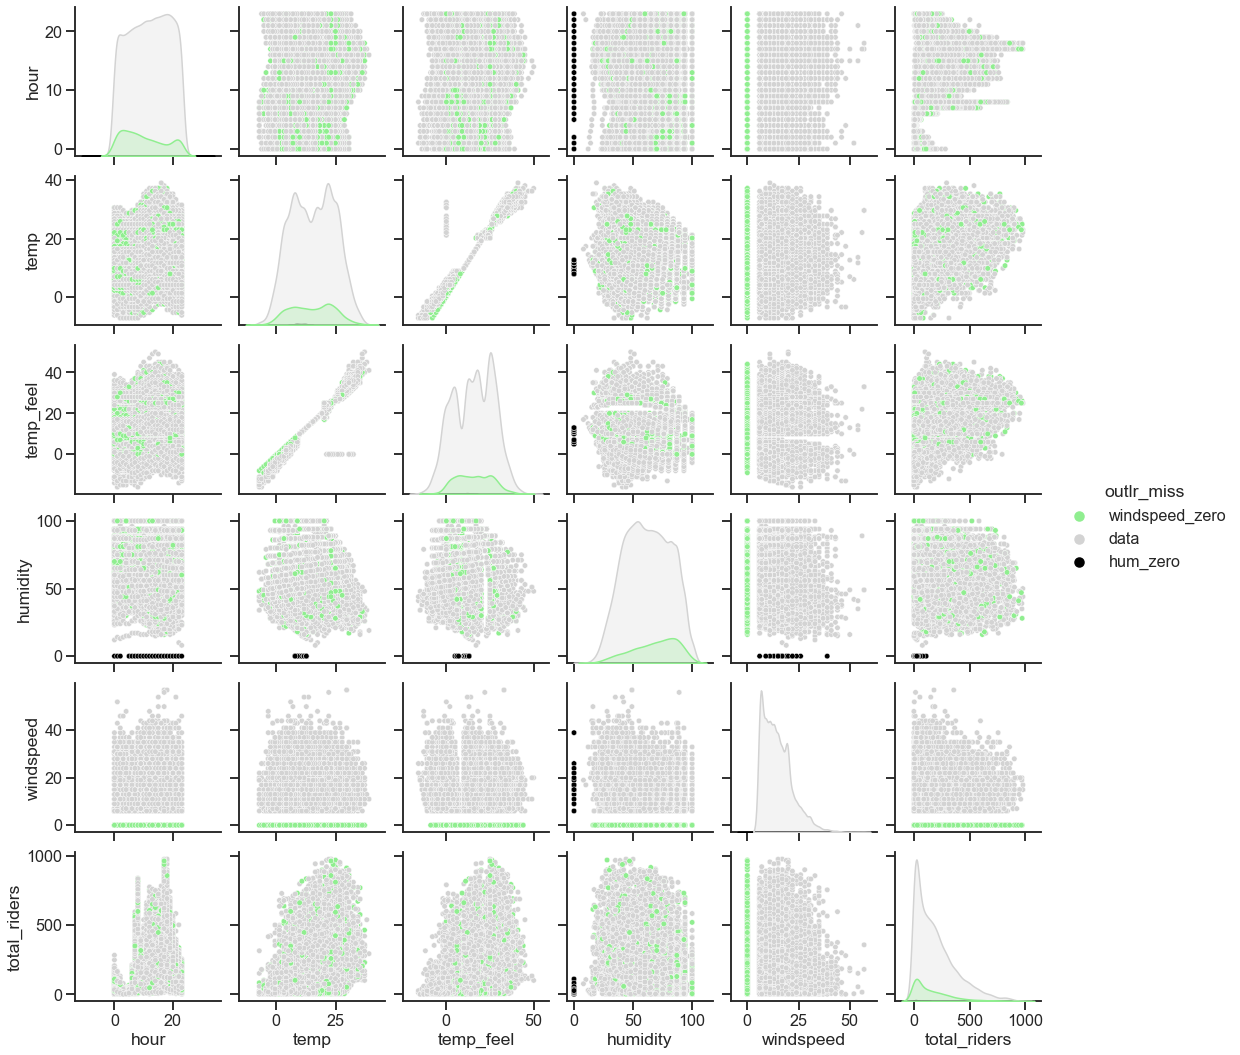

In [34]:
sns.set(context='talk', style='ticks', font_scale=0.98)
colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

sns.pairplot(df[ordFeatures + contFeatures + target + ['outlr_miss']].fillna(0),
            hue="outlr_miss", palette=colorPalette, plot_kws = {'s': 30})

plt.show()
plt.close('all')


3.4) Addressing Nulls, zeros, and outliers

3.4.1) Addressing Nulls and Zeros in Temperature 'temp' and 'atemp'

Plots with Temperature 'temp' and feeling-like temperature 'atemp' shows these two suspicious values: zeros, and outliers. The linear relationship between these two values becomes handy addressing suspicious points in this case. Below the Linear Regression and its use predicting suspicious points.
Observe, there are two data frames, one with the original Bike Sharing data: 'df_org' and another with tranformed/modified data: 'atemp'


In [36]:
# Linear Regression to address nulls, zeros, outliers in temperature
# creating a copy of the original data set
df_cpy = df.copy(deep=True)

ftr = ['windspeed_zero', 'data', 'hum_nan','hum_zero']
# the df1 will have Nulls for variables other than 'temp' and 'atemp'
df1 = df[df_cpy.outlr_miss.isin(ftr)]

df1 = df1[['temp','temp_feel']].dropna()

X   = df1['temp'].values.reshape(-1,1)
y   = df1['temp_feel'].values.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X, y)

df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_outlr']), 'atemp'] = df_cpy['temp']*regressor.coef_[0][0] + regressor.intercept_[0] 
df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_zero']), 'temp']   = df_cpy['temp']*regressor.coef_[0][0] + regressor.intercept_[0] 
df_cpy.loc[df_cpy['outlr_miss'].isin(['temp_nan']), 'temp']     = (df_cpy['atemp'] - regressor.intercept_[0])/regressor.coef_[0][0] 

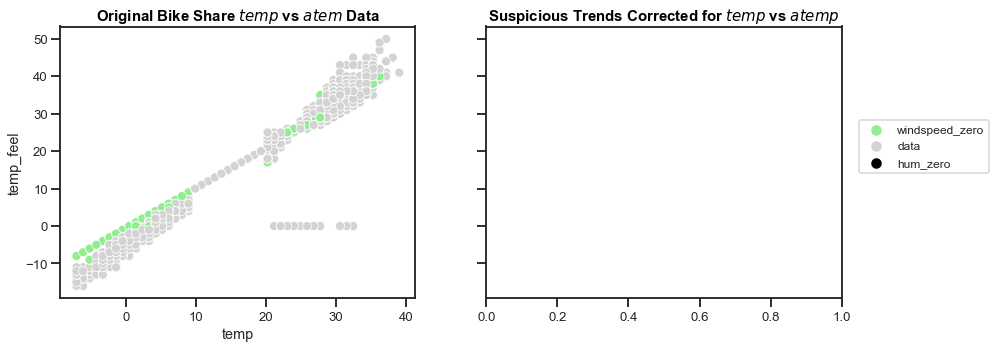

In [38]:


sns.set(context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(14,5)}) 

fontdictT={'fontsize': 15, 'weight' : 'bold', 'horizontalalignment': 'center'}

colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)

g1 = sns.scatterplot(x='temp', y='temp_feel', data=df.fillna(0),
                     hue="outlr_miss", palette=colorPalette, 
                     legend='brief', ax=axes[0])

g1.set_title('Original Bike Share $temp$ vs $atem$ Data',
            fontdict=fontdictT, color="black")

colorPalette = ['violet', 'orange', 'cyan']
ftr = ['atemp_zero', 'temp_nan','atemp_outlr']
g2 = sns.scatterplot(x='temp', y='temp_feel', data=df_cpy[df_cpy.outlr_miss.isin(ftr)],
                     hue="outlr_miss", palette=colorPalette,
                     legend=False, ax=axes[1])

g2.set_title('Suspicious Trends Corrected for $temp$ vs $atemp$',
            fontdict=fontdictT, color="black")

g1.legend(scatterpoints=1, loc='best',
           bbox_to_anchor=(2.65, 0.7), borderaxespad=1.,
           ncol=1, fontsize=12)

plt.show()
plt.close('all')



In [39]:


df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_outlr']), 'outlr_miss'] = 'data'
df_cpy.loc[df_cpy['outlr_miss'].isin(['temp_nan']), 'outlr_miss']    = 'data'
df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_zero']), 'outlr_miss']  = 'data'



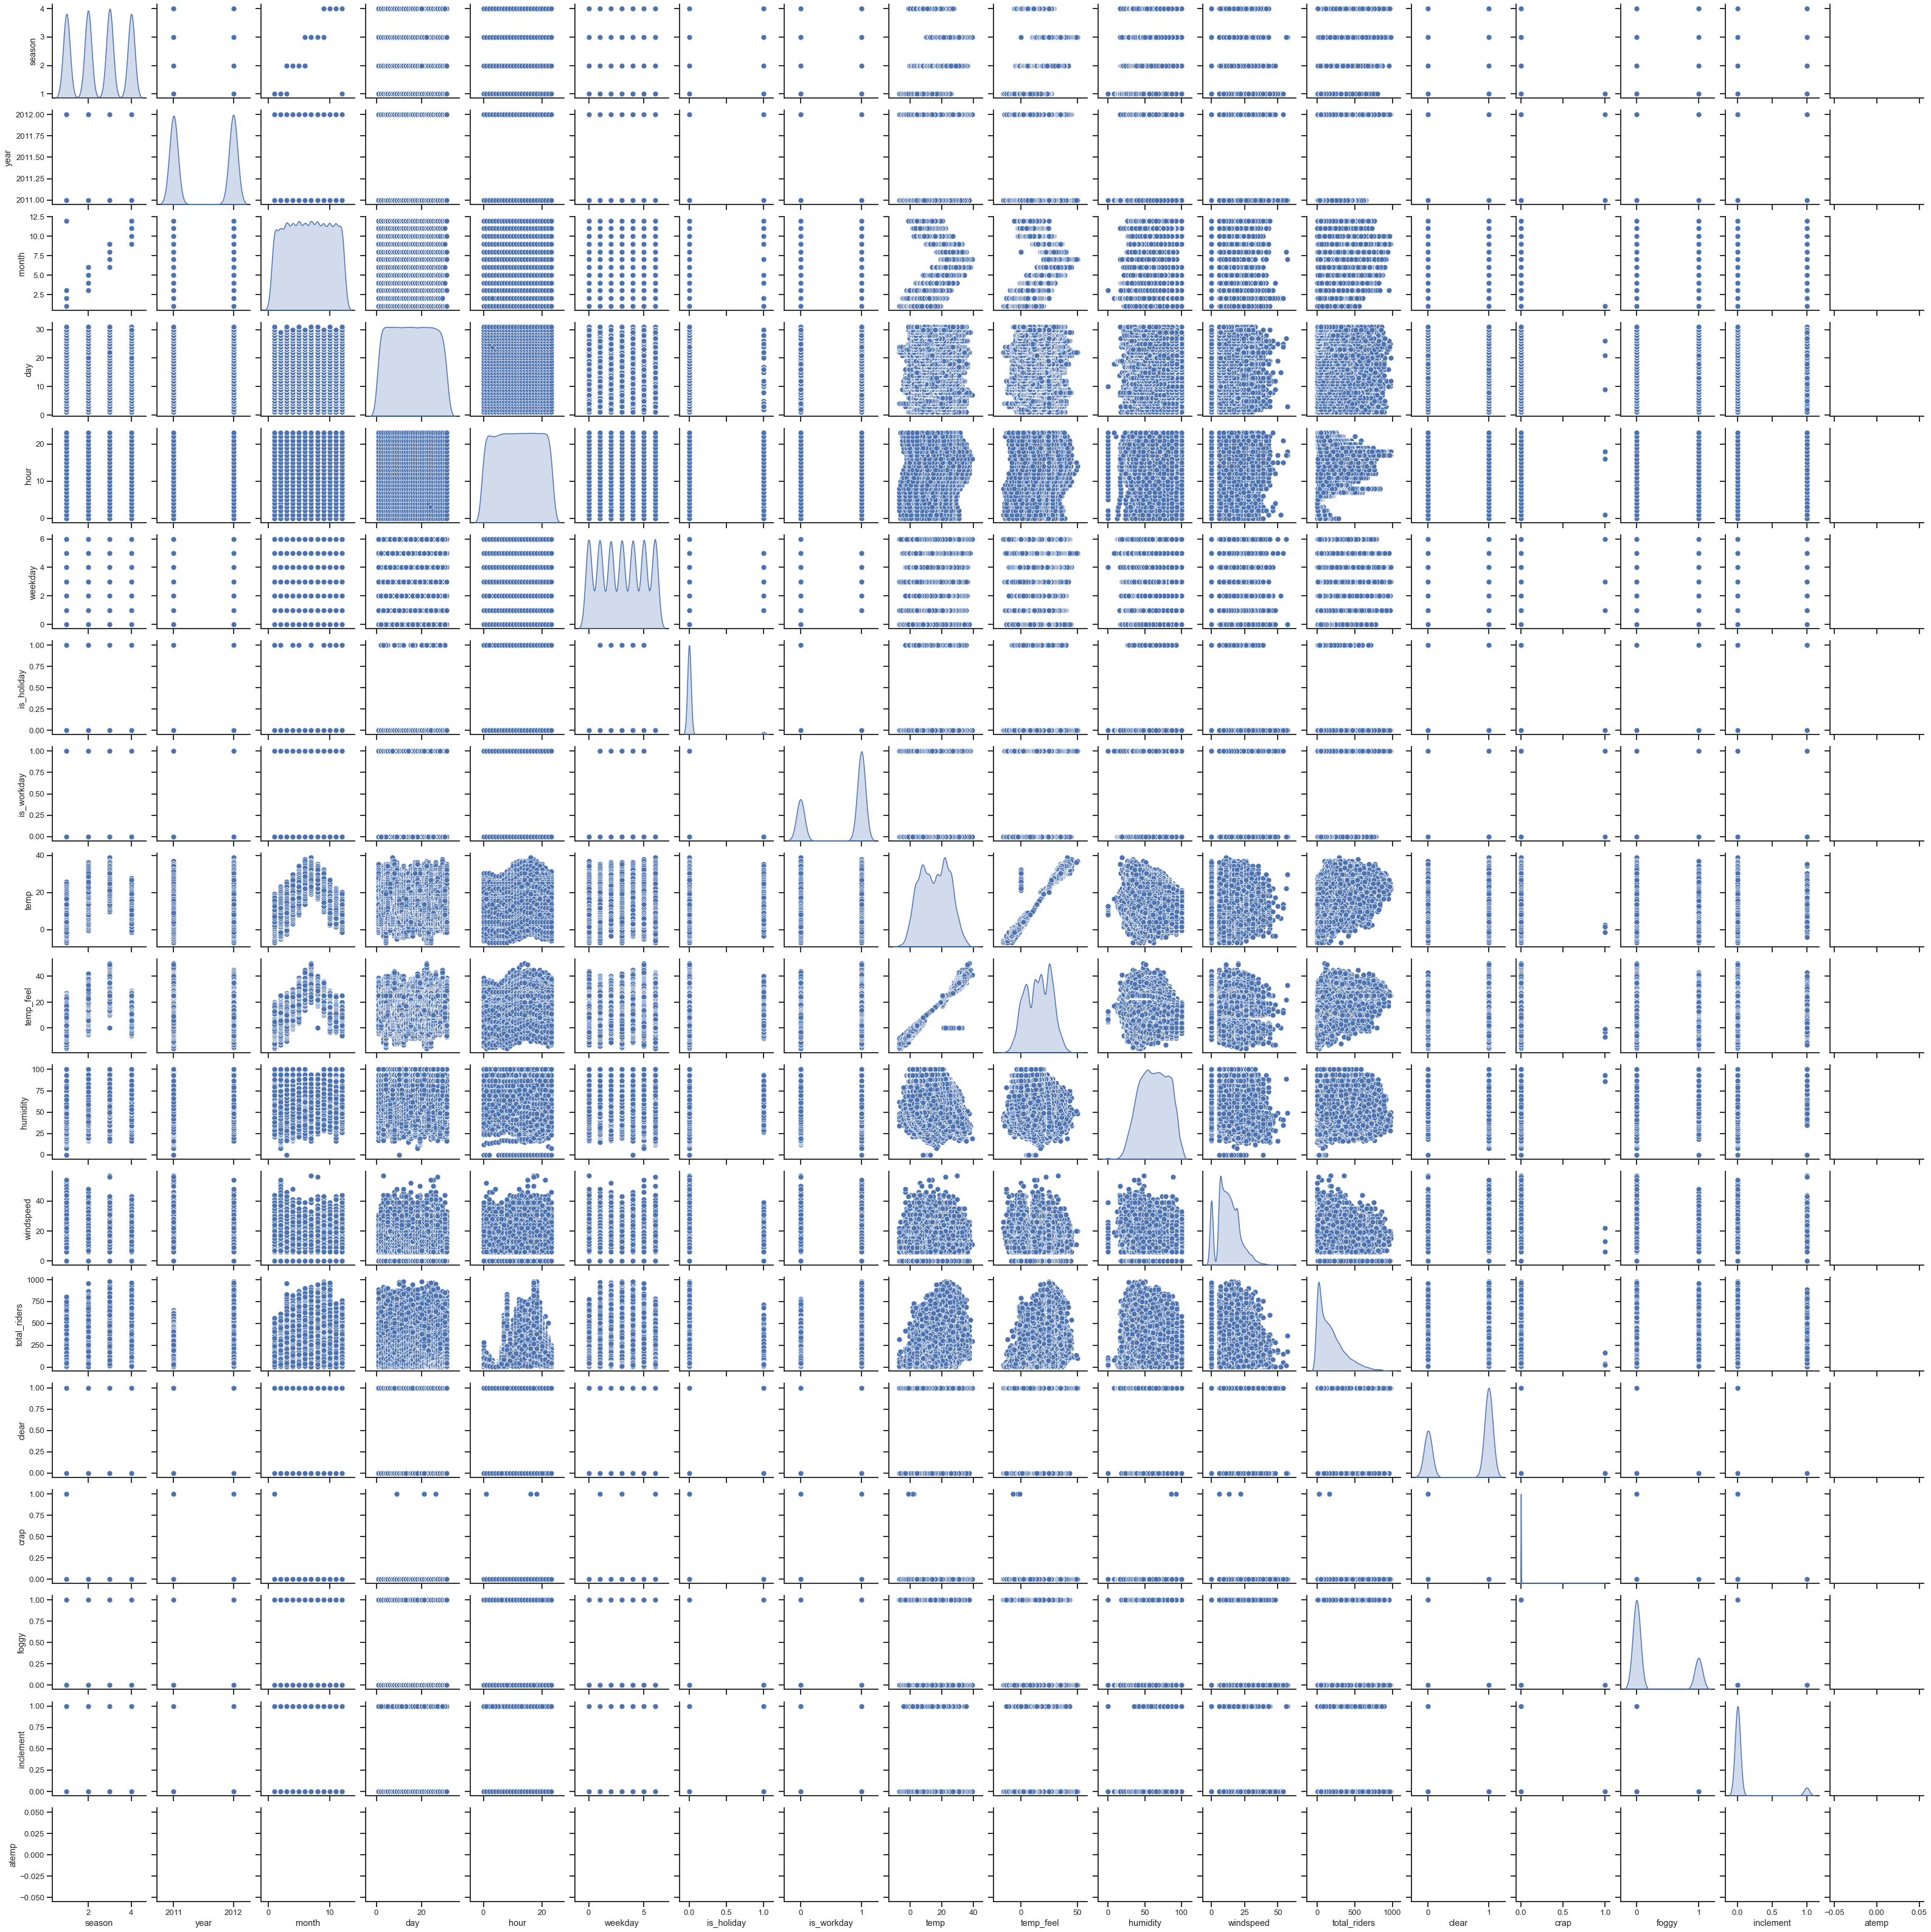

In [40]:
# Create a new dataframe of only numeric variables: !!not the dummy variables

#bike_nums = bike_hours[['temp', 'temp_feel', 'humidity', 'windspeed', 'total_riders']]

sns.pairplot(df_cpy, diag_kind='kde')
plt.show()